In [1]:
# Library imports
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import warnings

# File imports
from k_means import *

print("Done with Imports")

Done with Imports


# Example GMM and K-Means with Libraries

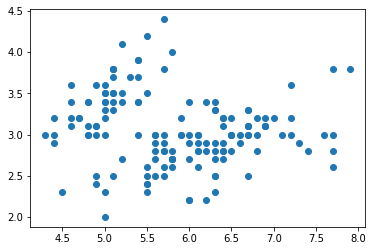

In [2]:
import pandas as pd
from pandas import DataFrame
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
 
# load the iris dataset
iris = datasets.load_iris()
 
# select first two columns 
X = iris.data[:, :2]
 
# turn it into a dataframe
d = pd.DataFrame(X)
 
# plot the data
plt.scatter(d[0], d[1])
plt.show()

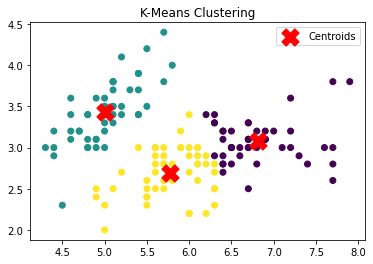

In [3]:
d = pd.DataFrame(X)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, n_init='auto')  # Assuming you want to divide the data into 3 clusters
kmeans.fit(X)
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
d['Cluster'] = labels

# Plot the data with different colors for each cluster
plt.scatter(d[0], d[1], c=d['Cluster'], cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('K-Means Clustering')
plt.legend()
plt.show()

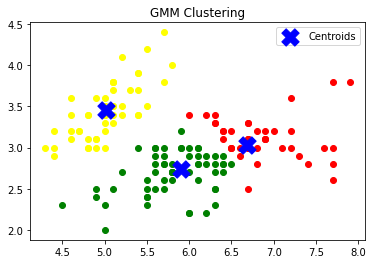

In [4]:
d = pd.DataFrame(X)

# Fit the GMM model for the dataset 
gmm = GaussianMixture(n_components = 3)
gmm.fit(d)
 
# Assign a label to each sample
labels = gmm.predict(d)
d['labels']= labels
d0 = d[d['labels']== 0]
d1 = d[d['labels']== 1]
d2 = d[d['labels']== 2]
 
# plot three clusters in same plot

plt.scatter(d0[0], d0[1], c ='r')
plt.scatter(d1[0], d1[1], c ='yellow')
plt.scatter(d2[0], d2[1], c ='g')

plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=300, c='blue', marker='X', label='Centroids')
plt.title('GMM Clustering')
plt.legend()
plt.show()

# Our K-Means

Iteration at breakage: 8


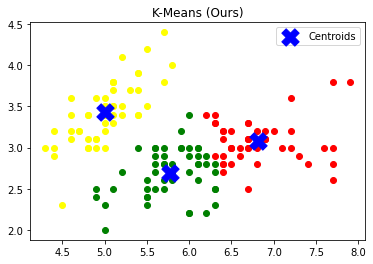

In [11]:
# Run K-Means++
num_classes, num_dimensions = 3, 2
init_c = kmeans_plusplus_initialization(X, num_classes)
means, points = k_means(X, init_c)

# Display the points in respective class
colors = ['red', 'yellow', 'green', 'blue']
for k in range(num_classes):
    for point in points[k]:
        plt.scatter(point[0], point[1], c=colors[k])

# Visualization Stuff
plt.scatter(means[:, 0], means[:, 1], s=300, c='blue', marker='X', label='Centroids')
plt.title("K-Means (Ours)")
plt.legend()
plt.show()

# Our GMM Code

In [21]:
# Constants
d = 2
num_classes = 3
n = len(X)
num_epochs = 15
EPSILON = 1e-10

# Parameters
means = kmeans_plusplus_initialization(X, num_classes)
covs = np.random.rand(num_classes, d, d) + EPSILON
posteriors = np.ones((n, num_classes)) / n
priors = np.ones(num_classes) / num_classes

# Get the PDF of a point for the gaussian
def normal(x, mean, cov):
    cov_det = np.abs(la.det(cov))
    try:
        cov_inv = la.inv(cov)
    except la.LinAlgError:
        cov_inv = np.linalg.pinv(cov)
            
    N = ((2 * np.pi) ** d) * cov_det
    N = N ** 0.5

    x_centered = x - mean
    exponent = -0.5 * x_centered.T @ cov_inv @ x_centered

    return np.exp(exponent) / N

def log_normal(x, mean, cov):
    # Get the (pseudo)inverse/determinant
    try:
        cov_inv = la.inv(cov)
        cov_det = np.abs(la.det(cov))
    except la.LinAlgError:
        cov_inv = np.linalg.pinv(cov)
        cov_det = np.abs(la.det(cov))

    log_pdf = -0.5 * d * np.log(2 * np.pi) - 0.5 * np.log(cov_det)
    x_centered = x - mean
    exponent = -0.5 * x_centered.T @ cov_inv @ x_centered

    log_pdf += exponent

    return log_pdf + EPSILON

In [24]:
# Loop through EM until convergence
for epoch in range(num_epochs):
    print("Epoch", epoch)
    
    # 1. Expectation Code
    for i, point in enumerate(X):        
        for k in range(num_classes):
            with warnings.catch_warnings():
                warnings.simplefilter("error", RuntimeWarning)
                try:
                    one = np.log(priors[k])
                except RuntimeWarning as e:
                    one = EPSILON 
                    print("We got a runtime warning", priors[k])
                    
                    
            two = log_normal(point, means[k], covs[k])
            posteriors[i, k] = one + two
            
    # Normalize posterior using log-sum-exp trick
    log_max = np.max(posteriors[i])
    log_sum = log_max + np.log(np.sum(np.exp(posteriors[i] - log_max)))
    posteriors[i] = np.exp(posteriors[i] - log_sum)

    # Calculate the priors     
    Ns = np.sum(posteriors, axis=0)
    priors = Ns / np.sum(Ns)
    
    for k in range(num_classes):
        # Check for Zero Ns[k]
        if Ns[k] != 0:
            means[k] = posteriors[:, k] @ X / Ns[k]
        else:
            print("Zero Ns[k] detected!")
            break

        centered_data = (X - means[k]) ** 2
        weighted_centered_data = centered_data * posteriors[:, k][:, np.newaxis]
        
        # Check for NaN in covs[k]
        if np.isnan(covs[k]).any():
            print("NaN values detected in covs[k]!")
            break
            
        covs[k] = np.dot(weighted_centered_data.T, centered_data) / Ns[k]


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14


Problem there are 0 points for class 0


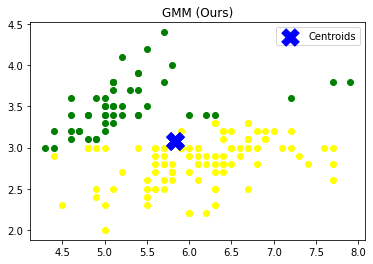

In [26]:
# Give assignment for each point
assignments = np.zeros(n, dtype=int)
for i in range(n):
    assignments[i] = np.argmax(posteriors[i])
    
# Put point into class list
class_points = [[] for _ in range(num_classes)]
for i, assignment in enumerate(assignments):
    class_points[assignment].append(X[i])
    
# Display the points in respective class
colors = ['red', 'yellow', 'green', 'blue']
for k in range(num_classes):
    points = np.array(class_points[k])
    if len(points) == 0:
        print("Problem there are 0 points for class", k)
        continue

    plt.scatter(points[:, 0], points[:, 1], c=colors[k])
plt.scatter(means[:, 0], means[:, 1], s=300, c='blue', marker='X', label='Centroids')
    
plt.title("GMM (Ours)")
plt.legend()
plt.show()